In [1]:
# Parameters
# Refer to injected parameters for any run.ipynb (similar cell below)
strain = "BY4741"
locus = "FKS1-HS1"
data = "refined_classification_with_missing.csv"  # for HS1: refined_classification_with_missing.csv

# Notebook to classify variants

## Import libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["svg.fonttype"] = "none"
from upsetplot import from_indicators
from upsetplot import UpSet

## Specify paths

In [3]:
# Input
data_path = f'../classified/{"_".join([strain,locus])}/{data}'
thresholds = f'../classified/{"_".join([strain,locus])}/thresholds.csv'
fungamr_path = "../fungamr/fungamrmut_filtered.tsv"

# Output
classified_outpath = f'../classified/{"_".join([strain,locus])}/'
graph_outpath = "../graphs/"
fungamr_outpath = "../fungamr/"

## Define functions

In [4]:
def refine_class(v, comp, threshdf):
    wtbound = threshdf.loc[
        (threshdf.compound == comp) & (threshdf.thresh == "low"), "val"
    ].values[0]
    resbound = threshdf.loc[
        (threshdf.compound == comp) & (threshdf.thresh == "up"), "val"
    ].values[0]

    if (comp in ["none", "dox"]) & (v > -0.7):
        if v >= wtbound:
            return "WT-like"
        else:
            return "slightly deleterious"
    elif (comp in ["none", "dox"]) & (v < -0.7):
        return "deleterious"
    else:
        if v <= wtbound:
            return "WT-like"
        elif v >= resbound:
            return "resistant"
        else:
            return "intermediary"

## Import data

In [5]:
df = pd.read_csv(data_path)
stddf = pd.read_csv(thresholds)

## Apply thresholds

In [6]:
df["refined_class"] = df.apply(
    lambda row: refine_class(row.s, row.compound, stddf), axis=1
)
df["sensres"] = df.refined_class.replace(
    {
        "intermediary": "resistant",
        "WT-like": "sensitive",
        "slightly deleterious": "sensitive",
        "deleterious": "deleterious",
    }
)
df.to_csv(data_path, index=False)

## Plot

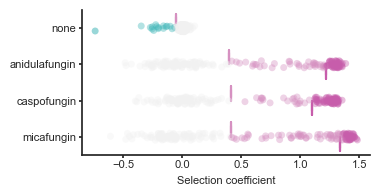

In [7]:
# Purge graph space
sns.set_theme(
    rc={
        "font.family": "Arial",
        "font.size": 8,
        "legend.title_fontsize": 8,
        "legend.fontsize": 8,
        "axes.labelsize": 8,
        "axes.titlesize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "xtick.major.pad": 2,
        "ytick.major.pad": 2,
        "xtick.bottom": True,
        "ytick.left": True,
        "xtick.major.size": 2,
        "ytick.major.size": 2,
    },
    style="ticks",
)

lclasses = [
    "resistant",
    "intermediary",
    "WT-like",
    "slightly deleterious",
    "deleterious",
]
custom_palette = ["#C75DAB", "#D691C1", "#F1F1F1", "#42B7B9", "#009B9E"]

fig = sns.catplot(
    df,
    x="s",
    y="compound",
    order=["none", "anidulafungin", "caspofungin", "micafungin"],
    hue="refined_class",
    hue_order=lclasses,
    palette=custom_palette,
    height=2,
    aspect=2,
    alpha=0.4,
    legend=False,
)

sns.boxplot(
    stddf,
    x="val",
    y="compound",
    hue="thresh",
    hue_order=["low", "up"],
    palette=["#D691C1", "#C75DAB"],
    fill=False,
    legend=False,
)

fig.set(xlabel="Selection coefficient", ylabel="")
plt.savefig(
    f'{graph_outpath}/{"_".join([strain,locus])}_classification_stripplot.svg',
    format="svg",
    dpi=300,
)

### Counts / %

In [8]:
perc = df.groupby(["compound", "sensres"])[["aa_seq"]].agg(
    nb_seq=("aa_seq", "nunique"),
)
tot = len(df.aa_seq.unique())
perc["%"] = perc.apply(lambda row: f"{row.nb_seq/tot:.1%}", axis=1)
perc

nb_seq      %
compound      sensres                   
anidulafungin resistant        92  52.0%
              sensitive        85  48.0%
caspofungin   resistant        96  54.2%
              sensitive        81  45.8%
micafungin    resistant        90  50.8%
              sensitive        87  49.2%
none          deleterious       1   0.6%
              sensitive       176  99.4%

### Show distributions

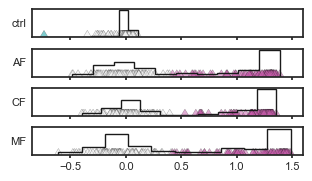

In [9]:
graphdf = df

abrev_drugs = {
    "none": "ctrl",
    "dox": "rep. ctrl",
    "anidulafungin": "AF",
    "caspofungin": "CF",
    "micafungin": "MF",
}
lclasses = ["resistant", "sensitive", "deleterious"]
custom_palette = ["#C75DAB", "#F1F1F1", "#009B9E"]

rc_dict = {
    "figure.figsize": (3.5, 1.9),
    "font.family": "Arial",
    "font.size": 8,
    "legend.title_fontsize": 8,
    "legend.fontsize": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "xtick.major.pad": 2,
    "ytick.major.pad": 2,
    "xtick.bottom": True,
    "ytick.left": False,
    "xtick.major.size": 2,
    "ytick.major.size": 2,
}
plt.rcParams.update(rc_dict)
fig, ax = plt.subplots(
    len(graphdf.compound.unique()), 1, sharex=True, gridspec_kw={"hspace": 0.4}
)

for i, c in enumerate(
    [x for x in abrev_drugs.keys() if x in graphdf.compound.unique()]
):
    axdf = graphdf[graphdf.compound == c]
    ax[i].hist(axdf.s, histtype="step", color="k")
    ax[i].scatter(
        axdf.s,
        np.zeros(axdf.s.shape),
        marker="d",
        s=50,
        c=axdf.sensres.map(dict(zip(lclasses, custom_palette))),
        edgecolors="k",
        linewidths=0.25,
        alpha=0.5,
    )
    ax[i].set_yticks([])
    ax[i].set_ylabel(abrev_drugs[c], rotation=0, ha="right", va="center")

plt.savefig(
    f'{graph_outpath}/{"_".join([strain,locus])}_distribution_effects_rug.svg',
    format="svg",
    dpi=300,
)

## UpSet plot on classified variants

In [10]:
parse_dict = {"resistant": True, "sensitive": False, "deleterious": False}

In [11]:
BYnnkCompWide = df.pivot_table(
    index="aa_seq", columns="compound", values=["s", "sensres"], aggfunc="first"
).reset_index()
BYnnkCompWide["max_s"] = BYnnkCompWide["s"].max(axis=1)
bincat = BYnnkCompWide["sensres"].replace(parse_dict)
bincat.rename(
    columns={
        "anidulafungin": "AF",
        "caspofungin": "CF",
        "micafungin": "MF",
        "none": "ctrl",
    },
    inplace=True,
)
compounds = ["AF", "CF", "MF"]
bincat = pd.concat([bincat, BYnnkCompWide[["max_s"]].droplevel(1, axis=1)], axis=1)
bincat

/tmp/ipykernel_91010/2269481645.py:7: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  bincat = BYnnkCompWide['sensres'].replace(parse_dict)


,AF,CF,MF,ctrl,max_s
0,False,False,False,False,0.320413
1,True,True,True,False,1.274885
2,True,True,True,False,1.308775
3,False,True,True,False,1.238131
4,False,True,True,False,1.256022
...,...,...,...,...,...
172,True,True,True,False,1.441898
173,True,True,True,False,1.227630
174,True,True,True,False,1.371139
175,True,True,True,False,1.355732


In [12]:
bincat.ctrl.unique()

array([False])

In [13]:
bincat.to_csv(f"{classified_outpath}/upsetplot.csv")

In [14]:
bincat = pd.read_csv(f"{classified_outpath}/upsetplot.csv", index_col=0)

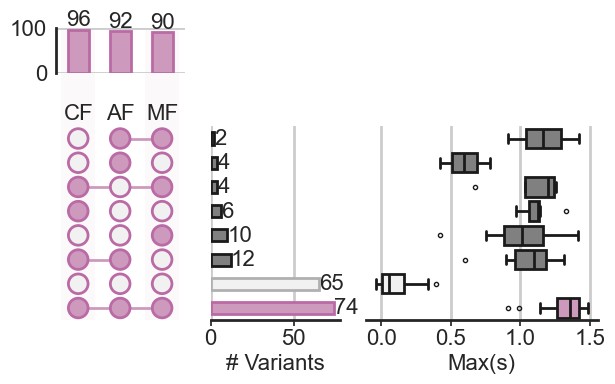

In [15]:
# Manuscript version
# For this plot, all sizes are doubled and the graph is ultimately reduced by 50% for the final panel

rc_dict = {
    "font.family": "Arial",
    "font.size": 16,
    "axes.linewidth": 2,
    "grid.linewidth": 2,
    "axes.labelsize": 16,
    "axes.titlesize": 16,
    "xtick.labelsize": 16,
    "ytick.labelsize": 16,
    "xtick.major.pad": 2,
    "ytick.major.pad": 2,
    "xtick.major.size": 4,
    "ytick.major.size": 4,
}

upset_obj = UpSet(
    from_indicators(compounds, data=bincat),
    orientation="vertical",
    facecolor="#cd9abe",
    other_dots_color="#F1F1F1",
    # show_percentages=True,
    show_counts=True,
    # min_subset_size=10,
    sort_by="cardinality",
    element_size=None,
    intersection_plot_elements=3,  # height/width of intersection barplot in matrix elements # needs to be 0 to be able to draw stacked_barplot
    totals_plot_elements=2,  # width/height of totals barplot in matrix elements
)

upset_obj.add_catplot(
    value="max_s",
    kind="box",
    color="grey",
    fliersize=3,
    linewidth=2,
    linecolor="k",
    elements=5,  # height in number of matrix elements
)

fig = plt.figure(figsize=(7, 3.8))

with plt.rc_context(rc_dict):
    d = upset_obj.plot(
        fig=fig
    )  # Assigns all plots to a dictionary containing axes subplots - same keys as gridspec returned by upset_obj.make_grid()

axt = d["totals"]
axm = d["matrix"]
ax0 = d[
    "intersections"
]  # Key corresponding to stacked barplot ('intersections' = intersection barplot)
ax1 = d["extra1"]  # Key corresponding to additional plot, in this case catplot

for i in [0, 1, 2]:
    axt.get_children()[i].set_color("#cd9abe")
    axt.get_children()[i].set_edgecolor("#ba6aa5")
    axt.get_children()[i].set_linewidth(2)

axm.set_xticklabels(axm.get_xticklabels(), rotation=0, ha="center")
axm.get_children()[0].set_edgecolor("#ba6aa5")
axm.get_children()[0].set_linewidth(2)

ax0.set_xlabel("# Variants")  # (unique aminoacid sequences)
ax1.set_xlabel("Max(s)")

if locus == "FKS1-HS1":
    for i in [0, 1, 2, 3, 4, 5, 6, 7]:
        ax0.get_children()[i].set_linewidth(2)
        if i <= 5:
            ax0.get_children()[i].set_color("grey")
            ax0.get_children()[i].set_edgecolor("k")
        elif i == 6:
            ax0.get_children()[i].set_color("#F1F1F1")
            ax0.get_children()[i].set_edgecolor("#b0b0b0")
        else:
            ax0.get_children()[i].set_edgecolor("#ba6aa5")

    ax1.get_children()[42].set_facecolor("#F1F1F1")
    ax1.get_children()[49].set_facecolor("#cd9abe")

elif locus == "FKS1-HS2":
    for i in [0, 1, 2, 3, 4, 5, 6]:
        ax0.get_children()[i].set_linewidth(2)
        if i <= 4:
            ax0.get_children()[i].set_color("grey")
            ax0.get_children()[i].set_edgecolor("k")
        elif i == 5:
            ax0.get_children()[i].set_edgecolor("#ba6aa5")
        else:
            ax0.get_children()[i].set_color("#F1F1F1")
            ax0.get_children()[i].set_edgecolor("#b0b0b0")
    ax1.get_children()[35].set_facecolor("#cd9abe")
    ax1.get_children()[42].set_facecolor("#F1F1F1")

elif locus == "FKS1-HS3":
    for i in [0, 1, 2, 3, 4, 5, 6]:
        ax0.get_children()[i].set_linewidth(2)
        if i <= 4:
            ax0.get_children()[i].set_color("grey")
            ax0.get_children()[i].set_edgecolor("k")
        elif i == 5:
            ax0.get_children()[i].set_edgecolor("#ba6aa5")
        else:
            ax0.get_children()[i].set_color("#F1F1F1")
            ax0.get_children()[i].set_edgecolor("#b0b0b0")

    ax1.get_children()[42].set_facecolor("#F1F1F1")
    ax1.get_children()[35].set_facecolor("#cd9abe")

else:
    print("No support for this hotspot")

plt.savefig(
    f"{graph_outpath}/upsetplot_resistance_overlap_{strain}_{locus}.svg",
    format="svg",
    dpi=300,
)

## Compare data with FungAMR

In [16]:
# import data from FungAMR for comparison (literature reports)
fungamr = pd.read_csv(fungamr_path, sep="\t")
fungamr = fungamr[
    (fungamr.locus == locus)
    & (fungamr.compound.isin(["anidulafungin", "caspofungin", "micafungin"]))
]  # filter for correct locus
fungamr = fungamr[
    (fungamr.best_res <= 4) | (fungamr.best_sens >= -4)
]  # exclude low confidence literature reports
fungamr["reported in Scer"] = fungamr.species.str.contains("Saccharomyces cerevisiae")

In [17]:
def bool_cross(x, y):
    if (x not in ["resistant", "sensitive"]) | (y not in ["resistant", "sensitive"]):
        return np.nan
    if x == y:
        if x == "resistant":
            return "resistant"
        else:
            return "sensitive"
    else:
        return "disagreement"

In [18]:
fungamr_merge = pd.merge(
    left=df,
    right=fungamr[
        [
            "Scer_mutation",
            "aa_seq",
            "compound",
            "phenotype",
            "best_res",
            "best_sens",
            "reported in Scer",
        ]
    ],
    on=["aa_seq", "compound"],
    how="outer",
)
fungamr_merge["litterature_support"] = fungamr_merge.apply(
    lambda row: bool_cross(row.sensres, row.phenotype), axis=1
)
agreements = fungamr_merge[fungamr_merge.litterature_support.notnull()].pivot_table(
    index="Scer_mutation",
    columns="compound",
    values="litterature_support",
    aggfunc="first",
)
best_scores = fungamr_merge[fungamr_merge.litterature_support.notnull()].pivot_table(
    index="Scer_mutation",
    columns="compound",
    values=["best_res", "best_sens", "reported in Scer"],
    aggfunc="first",
)
best_res = best_scores[[x for x in best_scores.columns if x[0] == "best_res"]].min(
    axis=1
)
best_sens = best_scores[[x for x in best_scores.columns if x[0] == "best_sens"]].max(
    axis=1
)
Scer_rep = best_scores[
    [x for x in best_scores.columns if x[0] == "reported in Scer"]
].any(axis=1)
agreements["best_res_across"] = best_res
agreements["best_sens_across"] = best_sens
agreements["reported in Scer"] = Scer_rep
agreements

compound,anidulafungin,caspofungin,micafungin,best_res_across,best_sens_across,reported in Scer
Scer_mutation,,,,,,
F639C,NaN,resistant,NaN,4.0,NaN,False
F639S,resistant,resistant,resistant,4.0,-8.0,False
F639V,NaN,resistant,resistant,1.0,NaN,True
F639Y,NaN,resistant,resistant,2.0,-8.0,True
L642Y,NaN,resistant,NaN,1.0,NaN,False
P647A,resistant,resistant,resistant,1.0,NaN,True
P647L,disagreement,disagreement,disagreement,NaN,-1.0,False
R645G,disagreement,disagreement,resistant,1.0,-1.0,False
S643F,resistant,resistant,resistant,4.0,-8.0,False


In [19]:
agreements.to_csv(f"{fungamr_outpath}/agreements_{strain}_{locus}.csv")